<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WIP info
---
Whole preprocessing takes few minutes, up to about 20 mins (for whole MURA). Since preprocessing of complete dataset is done only once, for that reason I didn't seem optimalization of this process as priority.
For preprocessing I set two main tasks. To cut region-of-interest from original image to get rid of most of the background (usually monochromatic with X-ray descriptive signs) that does not carry relevant information. And the second task is to normalize brightness (as brightness of input images vary a lot). For both tasks I tried to use different method methods (which can be found in Data_preprocessor.ipynb, in class ImageFilters). All of them could be used, but I choose empirically (training on part of the dataset) the best performing ones. \

Preprocessing could be made on-the-fly, mostly it could require change of method that currently loads data. However my reason agains doing this is the unnecessary overhead that would be added to training model. Data can be preprocessed only once and then used as many times during training without preprocessing them everytime. Advantage to this approach is unnecessity of storing preprocessed data, however the original dataset takes just 3.14Gb space on disk and preprocessed data even less. This cannot justify the overhead increased in data model, which is I didn't choose this solution. \

ImageDataGenerator has many built-in methods that allows very easy data augmentation accesible by its parameters. But offers just basic augmentation, which is why I needed to make my own preprocessing for getting ROI and normalization of image brightness. Currently used augmentations are just what I thought could be good, based on different models that I have inspected with regards to my specific input data (plus bit of empirical testing). I will check other possible augmentations (as brightness_range, etc.). \

Comments in first VGG cell are mine own, thought as most of them are definitions it is possible that some content of comments is worded very similar or same as in other sources. As for why "three_block_VGG" performs better than "simple_deep_CNN" I can't tell for sure. My guesses are that dropout layers losing too much of significant imformations in simple deep or that conv2D layer with higher output dimension perform better on this data. \

Training for XR_HUMERUS data with 40 epochs takes about 20 minutes. \
All generated graph are generated directly from model (fit_generator) output, so are completely legitimate. Visuals of plot were changed a bit to be more clear now. \


# Mura dataset
---
### Data:
Train and validation data for XR_HUMERUS from MURA dataset. \

---
### Code parts(description of colab cells):
**Imports** - contain all used imports with descriptions \
**Experimental** - code for experimenting with new features but is not currenly used in production version \
**Colab essentials** - when running code on Colab, mount Google Drive so data can be read from there. \
**Constants declaration** - declaring input parameters \
**Data augmentation** - defining functions for importing and augmenting data in Keras \
**Auxiliary functions** - any functions non-related to ML training, usually for graphical output \
**Model definitions** - Defining keras models \
**Training model** - initialization and training model






## Imports


In [0]:
# For graphical outpus, images preview and training results plot representation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras import backend
# Generator used for loading data into Keras model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Essentials for creating model architecture, model class, layers and optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform 
# Logger for logging results from training model
from tensorflow.keras.callbacks import CSVLogger

# System functions and path processing
import sys
import os

# Support functions for saving and loading model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

C:\DEV\Software\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\DEV\Software\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\DEV\Software\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\DEV\Software\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Experimental


#### Experimental settings for GPU training
Currently not working

In [0]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)

#     except RuntimeError as e:
#         print(e)

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
# print(device_lib.list_local_devices())

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

#### function for replacing layers in Model

In [0]:

# Function to replace/remove/add layer from Model (class Model, not Sequential)
# import re
# from keras.models import Model
# def return_dense_2():
#   return Dense(2, activation='softmax')

# def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
#                       insert_layer_name=None, position='after'):

#   # Auxiliary dictionary to describe the network graph
#   network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

#   # Set the input layers of each layer
#   for layer in model.layers:
#       for node in layer._outbound_nodes:
#           layer_name = node.outbound_layer.name
#           if layer_name not in network_dict['input_layers_of']:
#               network_dict['input_layers_of'].update(
#                       {layer_name: [layer.name]})
#           else:
#               network_dict['input_layers_of'][layer_name].append(layer.name)

#   # Set the output tensor of the input layer
#   network_dict['new_output_tensor_of'].update(
#           {model.layers[0].name: model.input})

#   # Iterate over all layers after the input
#   for layer in model.layers[1:]:

#       # Determine input tensors
#       layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
#               for layer_aux in network_dict['input_layers_of'][layer.name]]
#       if len(layer_input) == 1:
#           layer_input = layer_input[0]

#       # Insert layer if name matches the regular expression
#       if re.match(layer_regex, layer.name):
#           if position == 'replace':
#               x = layer_input
#           elif position == 'after':
#               x = layer(layer_input)
#           elif position == 'before':
#               pass
#           else:
#               raise ValueError('position must be: before, after or replace')

#           new_layer = insert_layer_factory()
#           if insert_layer_name:
#               new_layer.name = insert_layer_name
#           else:
#               new_layer.name = '{}_{}'.format(layer.name, 
#                                               new_layer.name)
#           x = new_layer(x)
#           print('Layer {} inserted after layer {}'.format(new_layer.name,
#                                                           layer.name))
#           if position == 'before':
#               x = layer(x)
#       else:
#           x = layer(layer_input)

#       # Set new output tensor (the original one, or the one of the inserted
#       # layer)
#       network_dict['new_output_tensor_of'].update({layer.name: x})

#   return Model(inputs=model.inputs, outputs=x)

# densenet_model = insert_layer_nonseq(densenet_model, 'fc1000', return_dense_2, insert_layer_name='Dense_2', position='replace')
# densenet_model.compile(optimizer='adam',
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

## Colab essentials
Running code on Colab and local requires slightly different, prerequisites (as different paths, etc.)
For differentiating where code is run, variable IN_COLAB is used, if True then run is in Colab (so rest of code can reflect that)

In [0]:
# check if code run on colab or local, if in Colab then True
IN_COLAB = 'google.colab' in sys.modules

# if run in Colab, then mount to run Google Drive file system
if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

##  Constants declaration


##### Constants that are expected to be directly changed (input parameters)

In [0]:
PATH_ORIGINAL_DATA="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"
COMMON_PATH = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/"

PATH_DESTINATION_CROPPED_RECT = COMMON_PATH + "cropped_rect/"
PATH_DESTINATION_CROPPED_SQUARE = COMMON_PATH + "cropped_square/"
PATH_DESTINATION_HIST_EQ = COMMON_PATH + "hist_eq/"
PATH_DESTINATION_CLAHE = COMMON_PATH + "clahe/"
# cropped_rect_clahe shows so far best results, currently used
PATH_DESTINATION_CROPPED_RECT_CLAHE = COMMON_PATH + "cropped_rect_clahe/"
PATH_DESTINATION_CROPPED_SQUARE_CLAHE = COMMON_PATH + "cropped_square_clahe/"

# Path to file with input data (and where outputs will be saved)
PATH = PATH_DESTINATION_CROPPED_RECT_CLAHE

IMG_SIZE=(224,224)
INPUT_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 40

##### Deriving other constants from given values

In [0]:
def files_number(PATH):
  """find number of files(recursively) in given directory(path)"""
  total = 0
  for root, dirs, files in os.walk(PATH):
      total += len(files)
  return total

# if run on local machine, change path to correspond my local system paths
if not IN_COLAB:
  PATH = "G:"+PATH[14:].replace('/', '\\\\')

PATH_TRAIN = PATH + 'train'
PATH_VALID = PATH + 'valid'
# calculate number of steps per epoch and validation steps from input values
# and constants
train_img_num = files_number(PATH_TRAIN)
valid_img_num = files_number(PATH_VALID)
NUMBER_STEPS_PER_EPOCH = train_img_num // BATCH_SIZE * 2
NUMBER_VALIDATION_STEPS = valid_img_num // BATCH_SIZE * 2

print("Number of steps per epoch:", NUMBER_STEPS_PER_EPOCH)
print("Number of validation steps:", NUMBER_VALIDATION_STEPS)

Number of steps per epoch: 38
Number of validation steps: 8


## Data augmentation
Currently image augmentation will be done by parameters of ImageDataGenerator.
If in future this solution will be insufficient, I will change it.

In [0]:
def ImageDataGenerator_def():
  datagen = ImageDataGenerator(
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=5,
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.15,
    # randomly shift images vertically` (fraction of total height)
    height_shift_range=0.15,
    # set range for random shear
    shear_range=0.01,
    # set range for random zoom
    zoom_range=0.04,
    # set mode for filling points outside the input boundaries
    fill_mode='reflect',
    # randomly flip images over horizontal axis
    horizontal_flip=True, 
    # set rescaling factor (applied before any other transformation)
    rescale=1. / 255,
    # randomly change brightness of picture 
    brightness_range=[0.7,1.2]
  )
  return datagen

def load_from_directory(dir_path, data_generator):
  '''Load images from directory while transforming data (based on parameters),
  contain other parameters for data augmentation'''
  batches = data_generator.flow_from_directory(
    # path to target directory from which data will be loaded
    dir_path,
    # resize all input images to IMG_SIZE
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    # class_mode='categorical',
    # color_mode='grayscale'
  )
  return batches

In [0]:
data_generator = ImageDataGenerator_def()

train_batches = load_from_directory(PATH_TRAIN, data_generator)
valid_batches = load_from_directory(PATH_VALID, ImageDataGenerator(rescale=1. / 255)
)

print("Found indices: ", end='')
print(train_batches.class_indices)
# print(train_batches.class_indices)

Found 1271 images belonging to 2 classes.


C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 287 images belonging to 2 classes.
Found indices: {'train_negative': 0, 'train_positive': 1}


In [0]:
# def preload_data(path_to_data, batch_generator):
#   limit = files_number(path_to_data)
#   cnt = 0
#   images = []
#   labels = []
#   while True:
#     tmp_images, tmp_labels = batch_generator.next()
#     for i in range(len(tmp_images)):
#       if cnt > limit:
#         return images, labels 
#       images.append(tmp_images[i])
#       labels.append(tmp_labels[i])
#       cnt += 1
#       if cnt%100 == 0:
#         print(cnt)

# train_images, train_labels = preload_data(PATH_TRAIN, train_batches)
# valid_images, valid_labels = preload_data(PATH_VALID, valid_batches)

## Auxiliary functions

In [0]:
def label_to_string(label):
  '''Map label value to descriptive string'''
  if(label == 0):
    return "Negative"
  else:
    return "Positive"


def show_sample_images(batches):
  '''Show one batch of training images (max 25 images)'''
  image_batch, label_batch = batches.next()
  plt.figure(figsize=(10,10))
  for n in range(min(len(image_batch), 25)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n][:,:,0], cmap=cm.gray)
    plt.title(label_to_string(label_batch[n]))
    plt.axis('off')
  plt.show()


def load_keras_model():
  '''Return loaded model saved model, based on value of PATH'''
  return load_model(PATH+"latest_model.h5")


def plot_model_graph():
  '''Print to output and save to file the graph of model layers
  and its parameters, based on value of PATH'''
  plot_model(loaded_model, to_file=PATH+"model_arch.png", show_shapes=True)


def plot_training(history):
  '''Plot diagnostic learning curves, print them to output and save them
  to file'''
  # plot loss
  plt.figure(figsize=(10,10))
  plt.subplot(211)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylim(bottom=0.4, top=0.8)
  plt.xlim(left=0, right = NUMBER_EPOCHS - 1)
  
  # plot accuracy
  plt.subplot(212)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylim(bottom=0.5, top=1)
  plt.xlim(left=0, right = NUMBER_EPOCHS - 1)

  plt.tight_layout(pad=1.0)
  # save plot to file
  plt.savefig(PATH + 'acc_loss_plot.png')
  plt.show()
  plt.close()


def cohen_kappa_metric(model_output, expected_output):
  '''calculate cohen kappa metric between model's output and expected output 
  (golden standard defined in MURA dataset paper) 
  
  Parameters
  ----------
  model_output : List
    a list of zeroes and ones as predicted results from model (zero for negative)
  expected_output : List
    a list of zeroes and ones as reported results for testing data

  Returns
  -------
  Float
    Cohen kappa metric score value
  '''
  from sklearn.metrics import cohen_kappa_score

  if len(model_output) != len(expected_output):
    print("Input strings for Kappa metrics don't have the same size.\
    Can't be compared")
    return 0.0
  else:
    return cohen_kappa_score(model_output, expected_output)

def predict(model, imgs):
  '''Use model to predict whether imgs are positive or negative

  Parameters
  ----------
  model : tensorflow.python.keras.engine.sequential.Sequential
    model used for prediction
  imgs: List
    list of images that we want to predict on

  Returns
  -------
  List
    A list list of zeroes and ones as prediction results (one for positive and
    zero for negative result)
  '''
  # TODO

  # for img in imgs:

In [0]:
# show_sample_images(train_batches)
# show_sample_images(valid_batches)

## Model definitions

#### Currently used model

In [0]:
'''
Activation function is method that define the output of neuron, different
functions use distinctive methods of how to figure out output.
I am using ReLU - Rectified linear unit. It is simple but effective function,
x = max(0,x)'''
ACTIVATION_FUNCTION='relu'

'''Kernel initializer define method used in setting the initial random weights
in layers. 
Currently using he_uniform, draws samples from a uniform distribution within
[-limit, limit] where limit is sqrt(6 / fan_in) where fan_in
is the number of input units in the weight ten'''
KERNER_INITIALIZER=he_uniform(0)

'''
Padding is a method to extend input image, so filter kernel can work as intended
even around borders.
Same - is method that guarantee output have SAME spatial dimensions as input'''
PADDING='same'

'''Optimizer is algorithm that change the attributes of neural network
 (weights and learning rate) in order to reduce loss value
 Stochastic gradient descent, which is improved by momentum method,
 lr is learning rate - it determines how big changes can be made in each step
 during training model, bigger lr means faster learning, but step too big can
 miss the best solution, thats why i can't be way to big'''
OPTIMIZER=SGD(lr=0.001, momentum=0.9)

'''Loss function evaluate loss/cost of specific event, in this case 
loss function describe how well does model perform by comparing ground truth(
label of what class is the training input image) with output from model'''
LOSS_FUNCTION='binary_crossentropy'

def three_block_VGG():
  """Three Block VGG Model"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING, input_shape=INPUT_SHAPE))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])
  return model

#### Other models (not currently used)

In [0]:
def basic_model():
  """Simple model, can't properly distinguish positive and negative images"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(Flatten())
  model.add(Dense(1, activation='softmax'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

def simple_deep_CNN():
  """Simple deeper model, can distuingish positive and negative images, 
  however with poor results"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=INPUT_SHAPE))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUMBER_CLASSES))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

def VGG16():
  '''Keras implentation of VGG16'''
  vgg16 = keras.applications.vgg16.VGG16()
  model = Sequential()
  for layer in vgg16.layers:
    model.add(layer)
  model.layers.pop()
  # for layer in model.layers:
  #   layer.trainable = False
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

def densenet():
  """Pre-trained Densenet201 from Keras library, with added layers to fit
  my classification problem"""
  densenet_model = keras.applications.densenet.DenseNet201(input_shape=INPUT_SHAPE,
                                              include_top=False, 
                                                weights='imagenet')
  densenet_model.trainable=False

  new_densenet = Sequential([
    densenet_model,
    Flatten(),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
  ])

  new_densenet.compile(optimizer=Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  return new_densenet

## Training model

In [0]:
# initialize model
model = three_block_VGG()

# print summary info about model and its layers
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
__________________________________________

C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40


C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


38/38 [==============================] - 60s 2s/step - loss: 0.8565 - acc: 0.5220 - val_loss: 0.6921 - val_acc: 0.5198
Epoch 2/40
38/38 [==============================] - 53s 1s/step - loss: 0.6881 - acc: 0.5294 - val_loss: 0.6751 - val_acc: 0.5699
Epoch 3/40
38/38 [==============================] - 50s 1s/step - loss: 0.6858 - acc: 0.5563 - val_loss: 0.6941 - val_acc: 0.5073
Epoch 4/40
38/38 [==============================] - 49s 1s/step - loss: 0.6911 - acc: 0.5137 - val_loss: 0.6874 - val_acc: 0.5052
Epoch 5/40
38/38 [==============================] - 49s 1s/step - loss: 0.6877 - acc: 0.5319 - val_loss: 0.6859 - val_acc: 0.5219
Epoch 6/40
38/38 [==============================] - 68s 2s/step - loss: 0.6873 - acc: 0.5336 - val_loss: 0.6817 - val_acc: 0.5491
Epoch 7/40
38/38 [==============================] - 44s 1s/step - loss: 0.6859 - acc: 0.5344 - val_loss: 0.6819 - val_acc: 0.6096
Epoch 8/40
38/38 [==============================] - 50s 1s/step - loss: 0.6822 - acc: 0.5559 - val_lo

C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\DEV\Software\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


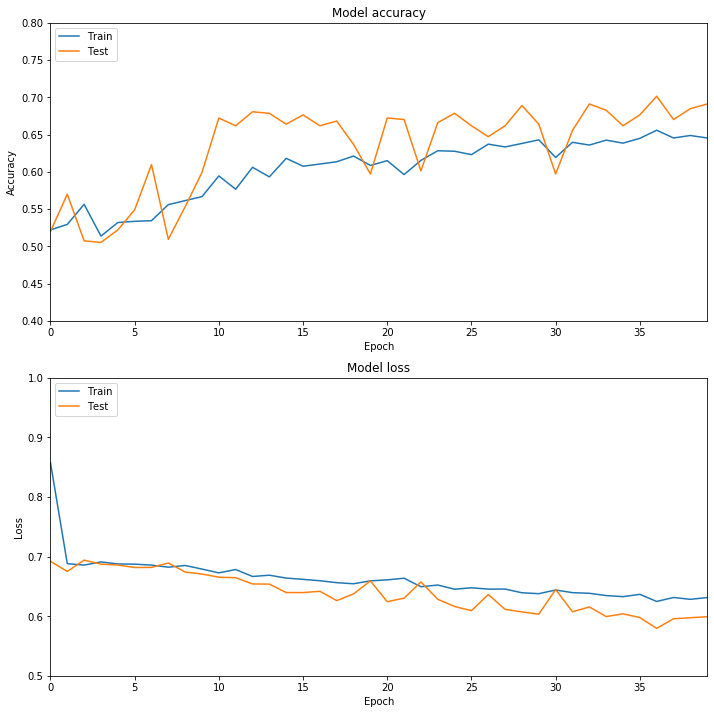

In [0]:
csv_logger = CSVLogger(PATH+'augmented_log.csv', append=True, separator=';')

# train model, as input takes training data, validation data
# steps per epoch, validations steps per epoch and number of epochs
# callbacks is used for logging output to file
# arguments that can be used later 
#   class_weight - if one of classes is underrepresented
#   use_multiprocessing - to modify processing
history = model.fit_generator(train_batches,
                    steps_per_epoch= NUMBER_STEPS_PER_EPOCH,
                    validation_data = valid_batches,
                    validation_steps = NUMBER_VALIDATION_STEPS,
                    epochs = NUMBER_EPOCHS,
                    callbacks=[csv_logger])

# Save created model
model.save(PATH+"latest_model.h5")

# show plots of loss/val_loss and accuracy/val_accuracy
plot_training(history)

In [0]:
# model = load_keras_model()

# from keras.preprocessing.image import img_to_array, load_img
# import cv2
# import numpy as np

# PATH_TEST = PATH+"train/test"

# test_batches = load_from_directory(PATH_TEST, ImageDataGenerator(rescale=1. / 255))


# # prediction = model.predict_proba(inputarray)
# # inputarray.shape

# # model1.predict_classes(inputarray)
# model.predict_classes(test_batches, batch_size=10)

In [0]:
# import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# model.fit(train_images, train_labels,
#           steps_per_epoch=32
#           epochs=40,
#           validation_data=(valid_images, valid_labels),
#           )